In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


In [2]:
from pymongo import MongoClient
client = MongoClient("mongodb://192.168.0.96:27017/")
db = client.cricket_data
collection1 = db.match_data
df_t20 = pd.DataFrame(list(collection1.find({"MatchType":"T20","Gender":"male"})))
df_australia = df_t20.query('HomeTeam == "Australia"')

In [3]:
T20_matches = list(df_australia['MatchId'])

collection2 = db.deliveries
t20 = pd.DataFrame(list(collection2.find({"MatchId":{"$in":T20_matches}})))
t20 = t20.query('Innings==1')

t20 = t20.drop(columns=['Batsman','Bowler','Nonstrike','Run_Batsman','Run_Extras'], axis=1)
t20.head()

Ball  Innings MatchId  Over Player_Out  Total_Runs Wicket_Kind  \
0    1        1  533297     0        NaN           0         NaN   
1    2        1  533297     0        NaN           0         NaN   
2    3        1  533297     0        NaN           0         NaN   
3    4        1  533297     0        NaN           1         NaN   
4    5        1  533297     0        NaN           0         NaN   

  Wicket_taken_By                       _id  
0             NaN  5c079d6623099c0b40b3b170  
1             NaN  5c079d6623099c0b40b3b171  
2             NaN  5c079d6623099c0b40b3b172  
3             NaN  5c079d6623099c0b40b3b173  
4             NaN  5c079d6623099c0b40b3b174

In [4]:
wk=[]
for i in t20['Wicket_Kind']:
    if i=='NaN':
        wk.append(0)
    else:
        wk.append(1)
new_row = pd.Series(wk)
t20['Wicket'] = new_row.values
t20.head()

Ball  Innings MatchId  Over Player_Out  Total_Runs Wicket_Kind  \
0    1        1  533297     0        NaN           0         NaN   
1    2        1  533297     0        NaN           0         NaN   
2    3        1  533297     0        NaN           0         NaN   
3    4        1  533297     0        NaN           1         NaN   
4    5        1  533297     0        NaN           0         NaN   

  Wicket_taken_By                       _id  Wicket  
0             NaN  5c079d6623099c0b40b3b170       0  
1             NaN  5c079d6623099c0b40b3b171       0  
2             NaN  5c079d6623099c0b40b3b172       0  
3             NaN  5c079d6623099c0b40b3b173       0  
4             NaN  5c079d6623099c0b40b3b174       0

In [5]:
data=t20.groupby(['MatchId']).aggregate({'Total_Runs':'sum'}).reset_index()
data.rename(columns={'Total_Runs':'Final_Score'},inplace=True)

In [8]:
data.head()

MatchId  Final_Score
0  1001349          177
1  1001351          186
2  1001353          193
3   226374          219
4   249227          235

In [12]:
data2=t20.groupby(['MatchId','Over']).aggregate({'Ball':'count','Wicket':'sum','Total_Runs':'sum'}).reset_index()
br=[]

for i in range(len(data2)):
    br.append((120-(data2['Over'][i])*6)-6)
se = pd.Series(br)
data2['Balls_Remaining']=se.values

cr=[]
run=0
for i in range(len(data2)-1):
    run = run+data2['Total_Runs'][i]
    cr.append(run)
    
    if data2['Over'][i]>data2['Over'][i+1]:
        run=0

cr.append(run+data2['Total_Runs'][len(data2)-1])
new_row = pd.Series(cr)
data2['Current_Score'] = new_row.values
data2['Runs_Per_Over'] = data2['Total_Runs']/data2['Ball']

wkt=[]
add=0
for i in range(len(data2)-1):
    add=add+data2['Wicket'][i]
    wkt.append(add)

    if data2['Over'][i] > data2['Over'][i+1]:
        add=0
wkt.append(wkt[-1]+data2['Wicket'][len(data2)-1])
new_row=pd.Series(wkt)
data2['Wickets_Fallen']=new_row.values
data2=pd.merge(data2,data,on='MatchId',how='left')
data2['Runs_Capacity']=data2['Final_Score']-data2['Current_Score']

In [13]:
data2.head()

MatchId  Over  Ball  Wicket  Total_Runs  Balls_Remaining  Current_Score  \
0  1001349     0     6       0           6              114              6   
1  1001349     1     6       0           7              108             13   
2  1001349     2     6       0           6              102             19   
3  1001349     3     6       0           8               96             27   
4  1001349     4     6       0          16               90             43   

   Runs_Per_Over  Wickets_Fallen  Final_Score  Runs_Capacity  
0       1.000000               0          177            171  
1       1.166667               0          177            164  
2       1.000000               0          177            158  
3       1.333333               0          177            150  
4       2.666667               0          177            134

In [14]:
teams_data = df_australia[['MatchId','AwayTeam','MatchVenue','TossWinner','Winner']]

le = preprocessing.LabelEncoder()
teams_data['AwayTeam'] = le.fit_transform(teams_data['AwayTeam'])
teams_data['MatchVenue'] = le.fit_transform(teams_data['MatchVenue'])


C:\Users\Ankit\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Ankit\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [15]:
teams_data.head()

MatchId  AwayTeam  MatchVenue   TossWinner       Winner
26   533297         8          15  West Indies  West Indies
40   406207         5          11    Australia    Australia
61   727917         5           4     Pakistan    Australia
76   412688         0           8    Australia    Australia
103  291356         2          11        India    Australia

In [16]:
toss=[]
for i in teams_data['TossWinner']:
    if i=='Australia':
        toss.append(1)
    else:
        toss.append(0)
new_toss = pd.Series(toss)
teams_data['Toss_Won'] = new_toss.values

win=[]
for i in teams_data['Winner']:
    if i=='Australia':
        win.append(1)
    else:
        win.append(0)
new_win = pd.Series(win)
teams_data['Match_Won'] = new_win.values
teams_data.head()

C:\Users\Ankit\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Ankit\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


MatchId  AwayTeam  MatchVenue   TossWinner       Winner  Toss_Won  \
26   533297         8          15  West Indies  West Indies         0   
40   406207         5          11    Australia    Australia         1   
61   727917         5           4     Pakistan    Australia         0   
76   412688         0           8    Australia    Australia         1   
103  291356         2          11        India    Australia         0   

     Match_Won  
26           0  
40           1  
61           1  
76           1  
103          1

In [17]:
data2 = pd.merge(data2, teams_data, on='MatchId', how='left')
data2

MatchId  Over  Ball  Wicket  Total_Runs  Balls_Remaining  Current_Score  \
0     1001349     0     6       0           6              114              6   
1     1001349     1     6       0           7              108             13   
2     1001349     2     6       0           6              102             19   
3     1001349     3     6       0           8               96             27   
4     1001349     4     6       0          16               90             43   
5     1001349     5     7       0           4               84             47   
6     1001349     6     6       0           6               78             53   
7     1001349     7     6       0           8               72             61   
8     1001349     8     6       0           6               66             67   
9     1001349     9     6       0           8               60             75   
10    1001349    10     6       1           4               54             79   
11    1001349    11     6       1          13               48             92   
12    1001349    12     6       0           4               42             96   
13    1001349    13     7       0           7               36            103   
14    1001349    14     6       0          16               30            119   
15    1001349    15     7       1          15               24            134   
16    1001349    16     6       0          10               18            144   
17    1001349    17     7       0           9               12            153   
18    1001349    18     6       2          10                6            163   
19    1001349    19     7       1          14                0            177   
20    1001351     0     6       0           7              114              7   
21    1001351     1     7       0          10              108             17   
22    1001351     2     6       0           1              102             18   
23    1001351     3     7       0          12               96             30   
24    1001351     4     6       0           8               90             38   
25    1001351     5     6       0          22               84             60   
26    1001351     6     6       0           4               78             64   
27    1001351     7     6       0           3               72             67   
28    1001351     8     6       0           7               66             74   
29    1001351     9     6       0           6               60             80   
...       ...   ...   ...     ...         ...              ...            ...   
1365   951347    10     6       0           4               54             70   
1366   951347    11     6       1          16               48             86   
1367   951347    12     6       0          11               42             97   
1368   951347    13     6       0           5               36            102   
1369   951347    14     6       0           8               30            110   
1370   951347    15     6       1           5               24            115   
1371   951347    16     6       0           4               18            119   
1372   951347    17     6       0          15               12            134   
1373   951347    18     7       0          17                6            151   
1374   951347    19     6       0          12                0            163   
1375   951355     0     6       0           5              114              5   
1376   951355     1     7       0          11              108             16   
1377   951355     2     6       0           5              102             21   
1378   951355     3     6       0          11               96             32   
1379   951355     4     6       0          10               90             42   
1380   951355     5     6       0          10               84             52   
1381   951355     6     6       0           5               78             57   
1382   951355     7     6       0    

In [17]:
features = data2[['AwayTeam', 'Toss_Won', 'Balls_Remaining', 'Current_Score', 'Wickets_Fallen', 'MatchVenue']]
labels = np.array(data2['Match_Won'])

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2)

In [20]:
def predict_method(feature_train, label_train, feature_test, label_test, model):
    model.fit(feature_train,label_train)
    predict_output = model.predict(feature_test)
    return accuracy_score(label_test,predict_output), predict_output

In [21]:
acc_score, pred_kneigh = predict_method(features_train, labels_train, features_test, labels_test, KNeighborsClassifier(n_neighbors = 350))
print('Accuracy for K neighbors', acc_score)

acc_score, pred_svc = predict_method(features_train, labels_train, features_test, labels_test, SVC())
print('Accuracy for SVM', acc_score)

acc_score, pred_dtc = predict_method(features_train, labels_train, features_test, labels_test, DecisionTreeClassifier())
print('Accuracy for Deision Tree Classifier', acc_score)

acc_score, pred_rfc = predict_method(features_train, labels_train, features_test, labels_test, RandomForestClassifier(n_estimators = 50, max_depth = 10))
print('Accuracy for Random Forest Classifier', acc_score)

Accuracy for K neighbors 0.5591397849462365


C:\Users\Ankit\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy for SVM 0.5842293906810035
Accuracy for Deision Tree Classifier 0.96415770609319
Accuracy for Random Forest Classifier 0.967741935483871


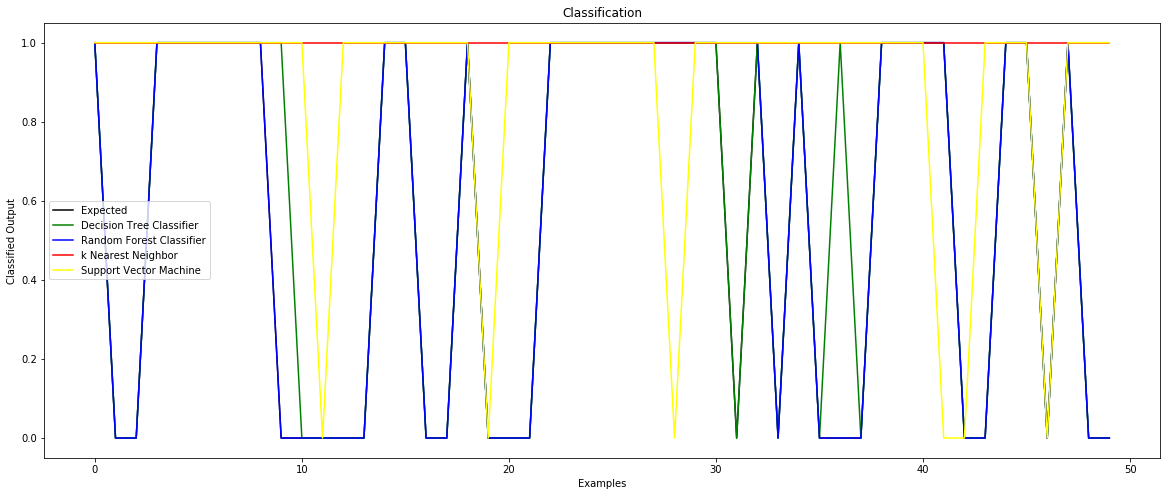

In [22]:
plt.figure(figsize=(20,8))
plt.plot(range(0,len(labels_test))[:50], labels_test[:50], color='black', label='Expected')
plt.plot(range(0,len(labels_test))[:50], pred_dtc[:50], color='green', label='Decision Tree Classifier')
plt.plot(range(0,len(labels_test))[:50], pred_rfc[:50], color='blue', label='Random Forest Classifier')
plt.plot(range(0,len(labels_test))[:50], pred_kneigh[:50], color='red', label='k Nearest Neighbor')
plt.plot(range(0,len(labels_test))[:50], pred_svc[:50], color='yellow', label='Support Vector Machine')


plt.title("Classification")
plt.xlabel("Examples")
plt.ylabel("Classified Output")
plt.legend()
plt.show()

Text(0.5, 0.98, 'Categorical Plotting')

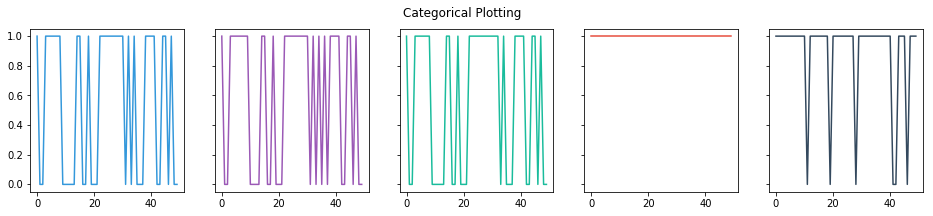

In [26]:
fig, axs = plt.subplots(1, 5, figsize=(16,3), sharey=True)

axs[0].plot(range(0,len(labels_test))[:50], labels_test[:50], color='#3498db')
axs[1].plot(range(0,len(labels_test))[:50], pred_dtc[:50], color='#9b59b6')
axs[2].plot(range(0,len(labels_test))[:50], pred_rfc[:50], color='#1abc9c')
axs[3].plot(range(0,len(labels_test))[:50], pred_kneigh[:50], color='#e74c3c')
axs[4].plot(range(0,len(labels_test))[:50], pred_svc[:50], color='#34495e')

fig.suptitle("Categorical Plotting")